In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
import scipy
import altair as alt
import matplotlib.pyplot as plt
import shap
import joblib
from tqdm import tqdm
import tensorflow as tf
from scipy.ndimage.filters import uniform_filter1d

from interaction_effects.marginal import MarginalExplainer
from interaction_effects.plot import summary_plot
from interaction_effects.utils import set_up_environment
import data

In [3]:
set_up_environment()

In [4]:
X_train = pd.read_csv('exoTrain.csv')
y_train = X_train['LABEL'].astype(int) - 1
X_train = X_train.values[:, 1:].astype(float)

X_test = pd.read_csv('exoTest.csv')
y_test = X_test['LABEL'].astype(int) - 1
X_test = X_test.values[:, 1:].astype(float)

In [5]:
X_train = (X_train - np.mean(X_train, axis=1, keepdims=True)) / \
           np.std(X_train, axis=1, keepdims=True)
X_test  = (X_test - np.mean(X_test, axis=1, keepdims=True)) / \
           np.std(X_test,  axis=1, keepdims=True)

In [6]:
y_train = np.expand_dims(y_train, axis=-1)
y_test  = np.expand_dims(y_test,  axis=-1)

In [7]:
X_train_stacked = np.stack([X_train, uniform_filter1d(X_train, axis=1, size=200)], axis=2)
X_test_stacked  = np.stack([X_test,  uniform_filter1d(X_test,  axis=1, size=200)], axis=2)

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=X_train_stacked.shape[1:]))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [9]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(X_train_stacked, y_train, 32), 
                           validation_data=(X_test_stacked, y_test), 
                           verbose=0, epochs=5,
                           steps_per_epoch=X_train_stacked.shape[1]//32)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(X_train_stacked, y_train, 32), 
                           validation_data=(X_test_stacked, y_test), 
                           verbose=2, epochs=40,
                           steps_per_epoch=X_train_stacked.shape[1]//32)

Epoch 1/40
99/99 - 6s - loss: 0.7457 - accuracy: 0.5369 - val_loss: 0.8125 - val_accuracy: 0.2737
Epoch 2/40
99/99 - 6s - loss: 0.7065 - accuracy: 0.5777 - val_loss: 0.7669 - val_accuracy: 0.3526
Epoch 3/40
99/99 - 6s - loss: 0.6622 - accuracy: 0.6152 - val_loss: 0.7150 - val_accuracy: 0.4842
Epoch 4/40
99/99 - 6s - loss: 0.6480 - accuracy: 0.6433 - val_loss: 0.6800 - val_accuracy: 0.5596
Epoch 5/40
99/99 - 6s - loss: 0.6324 - accuracy: 0.6458 - val_loss: 0.6673 - val_accuracy: 0.6175
Epoch 6/40
99/99 - 5s - loss: 0.6110 - accuracy: 0.6645 - val_loss: 0.6260 - val_accuracy: 0.6772
Epoch 7/40
99/99 - 6s - loss: 0.5801 - accuracy: 0.7008 - val_loss: 0.6005 - val_accuracy: 0.7088
Epoch 8/40
99/99 - 5s - loss: 0.5764 - accuracy: 0.7023 - val_loss: 0.6058 - val_accuracy: 0.6877
Epoch 9/40
99/99 - 6s - loss: 0.5649 - accuracy: 0.7216 - val_loss: 0.5561 - val_accuracy: 0.7298
Epoch 10/40
99/99 - 5s - loss: 0.5350 - accuracy: 0.7352 - val_loss: 0.5251 - val_accuracy: 0.7667
Epoch 11/40
99/99 -

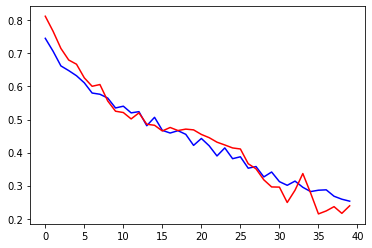

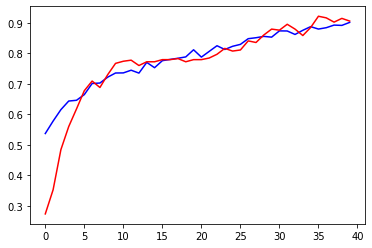

In [12]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['accuracy'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.show()

In [13]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(X_test_stacked)[:,0]

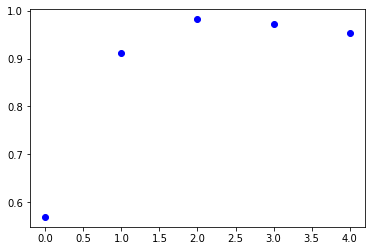

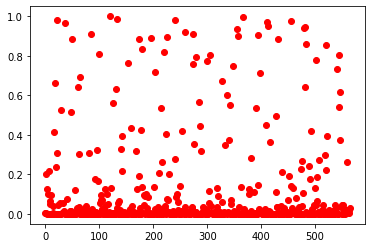

In [14]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()